In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
data = pd.read_excel("SAMBA scenario results all runs.xlsx","Capitalinv Variable and Fixed")

In [ ]:
data.sample(5)

In [5]:
data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)'])
data.columns.name = 'year'

In [ ]:
data.head(2)

In [6]:
data = data.stack('year')
data.name = 'value'

In [ ]:
data.head(2)

In [7]:
data = data.reset_index()
d = 0.06
data["discount_factor"] = (1+d)**(1-(data.year.astype(int)-2012))

In [8]:
data["discounted_value"] = data.value*data.discount_factor

In [9]:
new_data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).discounted_value.sum(level=['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).unstack("Parameter (million USD)").reset_index()

In [10]:
new_data.head(5)

Parameter (million USD),DMD,FUEL,CC RE,DR,CO2,CC,AnnualFixedOperatingCost,AnnualVariableOperatingCost,CapitalInvestment
0,1,1,1,1,1,1,145040.894155,264842.793937,557916.129207
1,1,1,1,1,1,2,145029.912063,264721.877829,557747.884279
2,1,1,1,1,2,1,140835.679793,268463.184119,507805.812989
3,1,1,1,1,2,2,140823.274886,268034.979319,508341.044098
4,1,1,1,1,3,1,141079.735686,269136.897516,505354.608094


### separate uncertain factors from results

In [11]:
inputs = new_data[['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC']]

### results (costs)

In [12]:
new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].describe()

Parameter (million USD),CapitalInvestment,AnnualFixedOperatingCost,AnnualVariableOperatingCost
count,3.240000e+02,324.000000,324.000000
mean,6.493549e+05,144072.376821,351253.089678
std,1.404637e+05,8470.677067,62988.566797
min,4.594565e+05,127878.275782,264721.877829
25%,5.462209e+05,137658.333176,302384.032938
50%,6.155210e+05,143580.802528,333234.143518
75%,7.030629e+05,148790.577682,401015.369259
max,1.141825e+06,166970.605547,534280.521865


In [13]:
new_data['tot_cost'] = new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [14]:
new_data['tot_cost'].describe()

count    3.240000e+02
mean     1.144680e+06
std      1.658876e+05
min      9.155641e+05
25%      1.016967e+06
50%      1.121849e+06
75%      1.238085e+06
max      1.721998e+06
Name: tot_cost, dtype: float64

In [15]:
new_data['annual_cost'] = new_data[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

### clustering and scenario discovery functions 

In [78]:
def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b                    
    return data

def clustering(n_clusters,data,xstring,ystring):
    data_norm = normalize(data)
    g = mixture.GaussianMixture(n_components=n_clusters)
    #g = mixture.GaussianMixture(n_components=n_clusters,random_state = 0)
    g.fit(data_norm)
    pred = g.predict(data_norm)+1
                    
    x=[]
    y=[]
    for i in range(0,len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    df = pd.DataFrame()
    df[xstring] = x
    df[ystring] = y
    df['class'] = pred
    
    return df

In [40]:
def get_prim(n_clusters, f_value,data,xstring,ystring,inputs):
    
    df = clustering(n_clusters,data,xstring,ystring)
    list_prim =[]
        
    for i in range(1,df['class'].max()+1):
        list_prim.append(prim.Prim(inputs, (df['class']==i),threshold=0.5,threshold_type=">"))

    boxes = []

    for i in range(0,len(list_prim)):
        boxes.append(list_prim[i].find_box())
        obj = (f_value*boxes[i].peeling_trajectory['coverage']-(1-f_value)*boxes[i].peeling_trajectory['density'])**2
        if 1 in boxes[i].peeling_trajectory['coverage']:
            coverage1 = np.where(boxes[i].peeling_trajectory['coverage']==1)[0][0]
            obj = obj.drop(obj.index[[coverage1]])
        k = obj.argmin()
        boxes[i].select(k)
    
    return [boxes,df]

### looking for the clusters that gives the best PRIM results (the number of clusters is chosen by the algorithm) 

In [18]:
oois = ['annual_cost','CapitalInvestment']

data = np.array([[new_data[oois[0]][0],new_data[oois[1]][0]]])
for i in range(1,len(new_data.index)):
    data = np.concatenate((data,np.array([[new_data[oois[0]][i],new_data[oois[1]][i]]])))

In [67]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

In [79]:
boxes_out,df_out = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)

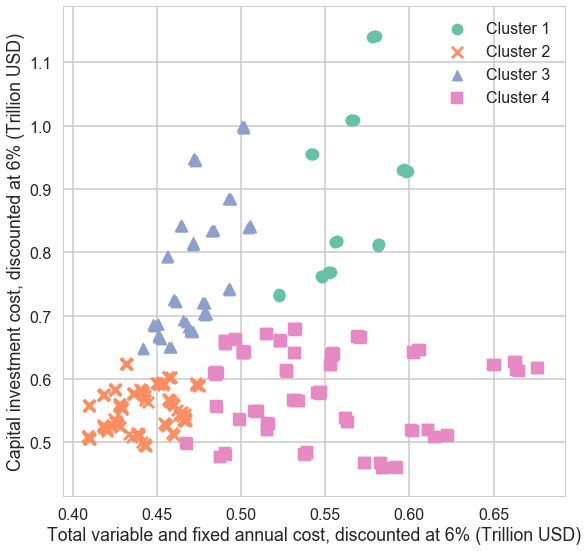

In [94]:
f = plt.figure(figsize=(9,9))
mycolors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3"]
mymarks = ["o","x","^","s"]
for (i,subdf) in df_out.groupby("class"):
    plt.scatter(1e-6*subdf.annual_cost,1e-6*subdf.CapitalInvestment,label="Cluster {}".format(i),c=mycolors[i-1],marker=mymarks[i-1])
    
plt.legend()
plt.xlabel("Total variable and fixed annual cost, discounted at 6% (Trillion USD)")
plt.ylabel("Capital investment cost, discounted at 6% (Trillion USD)")
plt.savefig("clusters_discounted_6.png")

### below are PRIM results for each cluster

#### cluster 1  

In [81]:
boxes_out[0].limits

,min,max,qp values
DR,3.0,3.0,5.231633e-13
CO2,1.0,2.0,3.586348e-04
DMD,2.0,3.0,3.586348e-04


In [82]:
boxes_out[0].coverage,boxes_out[0].density

(1.0, 0.75)

#### cluster 2 

In [83]:
boxes_out[1].limits

,min,max,qp values
DMD,1.0,2.0,1.731957e-09
DR,1.0,2.0,1.731957e-09


In [84]:
boxes_out[1].coverage,boxes_out[1].density

(1.0, 0.73611111111111116)

#### cluster 3 

In [85]:
boxes_out[2].limits

,min,max,qp values
DMD,2.0,3.0,0.000002
DR,1.0,2.0,0.000002
CO2,1.0,2.0,0.000235


In [86]:
boxes_out[2].coverage,boxes_out[2].density

(0.89473684210526316, 0.70833333333333337)

In [87]:
boxes_out[3].limits

,min,max,qp values
DR,2.0,3.0,0.000004
CO2,2.0,3.0,0.000162


In [88]:
boxes_out[3].coverage,boxes_out[3].density

(0.84905660377358494, 0.625)

In [90]:
table_out = pd.DataFrame()

In [93]:
table_out.append(pd.DataFrame(boxes_out[0]))

PandasError: DataFrame constructor not properly called!